<h1><center>Demo - Multimodal NLP Project</center></h1>
<h2><center>Visual Question Answering avec VizWiz dataset</center></h2>
<h3><center>Answer Visual Questions from People Who Are Blind</center></h3>

# 0. IMPORT

In [141]:
# IMPORT

from loguru import logger
import os, random, json
import numpy as np
import matplotlib.pyplot as plt

In [142]:
random.seed(42)

In [143]:
# PARAMETERS

NB_VAL_SAMPLES = 100
MAX_LENGTH = 48
NB_CANDIDATES = 20
BS = 8
ROOT = './data/'

# 1. DATASET

In [144]:
# VOCABULAIRE

import json
from collections import defaultdict

all_answers_by_type = defaultdict(set)

for split in ['train', 'val']:

    with open(f"./data/annotations/{split}.json") as f:
        data = json.load(f)

    for element in data:
        answer_type = element['answer_type']
        answers = [a['answer'] for a in element['answers']]
        all_answers_by_type[answer_type].update(answers)

keys = all_answers_by_type.keys()
for ans_type in keys:
    print(f'{ans_type:.>20}: ({len(all_answers_by_type[ans_type])}) \t eg. {list(all_answers_by_type[ans_type])[:5]}')

...............other: (42879) 	 eg. ['', 'honeywell blank screen', '375 for 20to 25 minutes do not puncture', 'ben new', 'bottle water laptop backpack']
..............yes/no: (974) 	 eg. ['ketchup', 'clam chowder', 'no too close', 'yes apple brand mouse', 'yes turn bottle to right little i am unable to read']
........unanswerable: (7311) 	 eg. ['', 'no too close', 'operating system unable to start start up repair trying to fix problem', 'cook before eating', 'pizza sauce']
..............number: (629) 	 eg. ['44', '24ºf', '124', '470', 'size 1']


In [ ]:
# DATASET CLASS

from PIL import Image
import torch
from torch.utils.data import Dataset
from transformers import CLIPProcessor

class VizWizVQADataset(Dataset):
    
    def __init__(self, root_folder, split, answers_dict, nb_candidates, max_length, 
                 processor: CLIPProcessor, nb_samples: int, reform_quest: bool=False):
        """
        root_folder : dossier racine du dataset
        split : 'train' ou 'val'
        answers_dict : dictionnaire type_reponse -> liste de réponses possibles
        nb_candidates : nombre de candidats à considérer
        processor : CLIPProcessor pour images + texte
        nb_samples : nombre d'exemples à charger (-1 pour utiliser tout le dataset)
        reform_quest : booléen qui indique si on doit utilisée les questions reformulées (cf. partie améliorée)
        """
        super().__init__()
        self.root_folder = root_folder
        self.split = split
        self.processor = processor
        self.answers_dict = answers_dict
        self.nb_candidates = nb_candidates
        self.max_length = max_length
        self.nb_samples = nb_samples
        self.reform_quest = reform_quest
        self.samples = []

        all_answers = set()
        for lst in answers_dict.values():
            all_answers.update(lst)
        self.vocab = {ans: idx for idx, ans in enumerate(all_answers)}

        # Pour s'assurer d'avoir les memes images dans val on prend le fichier d'annotations créer reform_val.json
        ann_path = os.path.join(root_folder, 'annotations', f'reform_{split}.json')
        with open(ann_path) as f:
            ann = json.load(f)

        counter = 0
        for el in ann:
            
            answer_type = el['answer_type']
            if answer_type == 'unanswerable':
                continue

            if (self.nb_samples > 0) and (counter >= self.nb_samples):
                break

            image_name = el['image']
            image_path = os.path.join(root_folder, split, image_name)
            if not os.path.isfile(image_path):
                raise FileNotFoundError(f"Le fichier {image_path} n'existe pas !")
            
            if not self.reform_quest:
                question = el['question']
            else:
                question = el['reform_question']
            answers = [a['answer'] for a in el['answers']]

            # Label : réponse la plus fréquente
            ans_dict = {ans: answers.count(ans) for ans in set(answers)}
            label_str = max(
                (k for k in ans_dict if k != 'unanswerable'),
                key=lambda k: (ans_dict[k], len(k))
            )

            # Candidats
            candidates_str = random.sample(list(answers_dict[answer_type]), self.nb_candidates - 1)
            candidates_str.append(label_str)
            random.shuffle(candidates_str)

            self.samples.append({
                "image_path": image_path,
                "question": question,
                "label": label_str,
                "candidates": candidates_str
            })

            counter += 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Charger l'image
        image = Image.open(sample['image_path']).convert("RGB")

        # Générer les textes pour CLIP : question + candidat
        texts = [f'{sample['question']} {c}' for c in sample['candidates']]

        # Préparer l'entrée CLIP
        inputs = self.processor(text=texts, images=image, return_tensors="pt", padding="max_length",
                                max_length=self.max_length, truncation=True)

        # Conversion du label en indice
        label_idx = sample['candidates'].index(sample['label'])
        candidates_idx = torch.arange(len(sample['candidates']))    # juste 0..N-1

        return {
            "pixel_values": inputs['pixel_values'].squeeze(0),
            "input_ids": inputs['input_ids'],                       # texte tokeniser pour cq candidat [num_candidates, seq_len=77]
            "attention_mask": inputs['attention_mask'],             # masque de input_ids : 1 -> token, 0 -> padding
            "label": torch.tensor(label_idx, dtype=torch.long),     # idx du label dans raw_candidates
            "candidates": candidates_idx,                           # listes des idx 0...N-1
            "raw_candidates": sample['candidates'],                 # texte des candidats (pour vizualisation)
            "question_text": sample['question'],                    # texte de la question (pour visualisation)
            "image_path" : sample['image_path']
        }


In [146]:
from transformers import CLIPProcessor
from torch.utils.data import DataLoader

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# --- Initial Q

dataset_val = VizWizVQADataset(root_folder=ROOT, split='val', answers_dict=all_answers_by_type,
                    nb_candidates=NB_CANDIDATES, max_length=MAX_LENGTH, processor=processor, 
                    nb_samples=NB_VAL_SAMPLES, reform_quest=False)

val_loader = DataLoader(dataset_val, batch_size=BS, shuffle=False, num_workers=0)

# --- Reform Q

rdataset_val = VizWizVQADataset(root_folder=ROOT, split='val', answers_dict=all_answers_by_type,
                    nb_candidates=NB_CANDIDATES, max_length=MAX_LENGTH, processor=processor, 
                    nb_samples=NB_VAL_SAMPLES, reform_quest=True)

rval_loader = DataLoader(rdataset_val, batch_size=BS, shuffle=False, num_workers=0)


# 3. MODELS

In [147]:
# device selection: cuda > mps > cpu

if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) is not None \
    and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Device:", device)

Device: mps


In [148]:
# BASELINE (modèle initial CLIP)

from transformers import CLIPModel

model_base = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

In [149]:
# FINETUNING (modèle finetuné avec 400 exemples du split train)

from transformers import CLIPModel

model_fnt = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
best_path = f"./weights/best_clip{MAX_LENGTH}.pth"

# charger meilleur modèle
if os.path.exists(best_path):
    model_fnt.load_state_dict(torch.load(best_path, map_location=device))
    print("Meilleur modèle chargé depuis", best_path)


Meilleur modèle chargé depuis ./weights/best_clip48.pth


In [150]:
# FINETUNING with REFORM QUESTION 
# (modèle finetuné avec 400 exemples du split train, 
# en utilisant les questions reformulées par le LLM Mistral-7B)

from transformers import CLIPModel

model_fntrq = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
best_path = f"./weights/reform_best_clip{MAX_LENGTH}.pth"

# charger meilleur modèle
if os.path.exists(best_path):
    model_fntrq.load_state_dict(torch.load(best_path, map_location=device))
    print("Meilleur modèle chargé depuis", best_path)


Meilleur modèle chargé depuis ./weights/reform_best_clip48.pth


# 4. UTILS

In [151]:
import torch
from torch.nn.functional import cosine_similarity
from loguru import logger

def eval_loop(model, val_loader, device, temperature, log=True):

    model = model.to(device)
    model.eval()  # mode évaluation

    total = 0
    correct = 0
    n = len(val_loader)

    with torch.no_grad():

        for i, batch in enumerate(val_loader):

            # Déplacer les tenseurs sur le bon device
            pixel_values = batch["pixel_values"].to(device)         # [B, 3, 224, 224]
            input_ids = batch["input_ids"].to(device)               # [B, num_candidates, seq_len]
            attention_mask = batch["attention_mask"].to(device)     # [B, num_candidates, seq_len]
            labels = batch["label"].to(device)                      # [B]

            batch_size, num_candidates, seq_len = input_ids.shape

            # Aplatir les candidats pour passer au modèle
            flat_input_ids = input_ids.view(-1, seq_len)            # [B*num_candidates, seq_len]
            flat_attention_mask = attention_mask.view(-1, seq_len)  # [B*num_candidates, seq_len]

            # Embeddings texte et image
            text_embeds = model.get_text_features(flat_input_ids, attention_mask=flat_attention_mask)
            text_embeds = text_embeds.view(batch_size, num_candidates, -1)  # [B, num_candidates, hidden_size]

            image_embeds = model.get_image_features(pixel_values)  # [B, hidden_size]
            image_embeds = image_embeds.unsqueeze(1)               # [B, 1, hidden_size]

            # Similarité cosinus : [B, num_candidates]
            similarities = cosine_similarity(image_embeds, text_embeds, dim=-1)# [B, num_candidates]
            if temperature != None:
                similarities = similarities / temperature
            else: # CLIP on basic config
                scale = model.logit_scale.exp()
                similarities = similarities * scale

            # Prédiction : indice du candidat le plus similaire
            preds = similarities.argmax(dim=1)

            # Calcul précision
            correct += (preds == labels).sum().item()
            total += batch_size

            if log is not None and (i % 3)==0 or (i==(n-1)):
                logger.info(f'Batch {i}/{n-1} \t running_accuracy = {correct/total:.4f}')

    accuracy = correct / total

    return accuracy


In [152]:
def plot_vqa_sample(idx, batch, sorted_indices, distributed_sim, num_top=20):    

    # Extraction des données
    img = Image.open(batch['image_path'][idx])
    question = batch['question_text'][idx]
    candidates = np.array([c[idx] for c in batch['raw_candidates']])
    label_idx = batch['label'][idx].item()
    gt_text = candidates[label_idx]

    # Tri des prédictions
    idx_triés = sorted_indices[idx]
    top_candidates = candidates[idx_triés]
    top_probs = distributed_sim[idx][idx_triés]

    # Configuration de la figure
    fig = plt.figure(figsize=(18, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.2, 1, 1])
    
    # 1. Affichage Image
    ax_img = fig.add_subplot(gs[0])
    ax_img.imshow(img)
    #ax_img.set_title(f"Question: {question}", fontsize=10, pad=10, wrap=True)
    ax_img.axis('off')

    # 2. Affichage des Barres (en 2 colonnes de 10)
    max_p = top_probs[0]
    for col in range(2):
        ax = fig.add_subplot(gs[col + 1])
        start, end = col * 10, (col + 1) * 10
        
        y_pos = np.arange(10)
        probs_chunk = top_probs[start:end]
        cand_chunk = top_candidates[start:end]

        # Définition des couleurs : Vert si correct, Orange si Top 1 faux, Bleu sinon
        colors = []
        for i in range(start, end):
            if i == 0:
                colors.append('limegreen' if top_candidates[0] == gt_text else 'coral')
            elif top_candidates[i] == gt_text:
                colors.append('limegreen') # Souligne la réponse correcte si elle est plus loin
            else:
                colors.append('skyblue')

        bars = ax.barh(y_pos, probs_chunk, color=colors, alpha=0.8)
        
        # Annotations
        for i, bar in enumerate(bars):
            # Texte du candidat (à gauche)
            ax.text(0, bar.get_y() + bar.get_height()/2, f" {cand_chunk[i]}", 
                    va='top', ha='left', fontsize=10, fontweight='bold')
            # Valeur de probabilité (à droite de la barre)
            ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f" {probs_chunk[i]:.4f}", 
                    va='bottom', ha='left', fontsize=10)

        ax.set_xlim(0, max_p * 1.2)
        ax.invert_yaxis()
        ax.axis('off')
        ax.set_title(f"Top {start+1}-{end}", fontsize=9, color='gray')

    # Titre global avec indicateur de succès
    is_correct = (top_candidates[0] == gt_text)
    status = "CORRECT" if is_correct else f"WRONG (GT: {gt_text})"
    fig.suptitle(f"{status} - Question: {question}", fontsize=14, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()
    plt.close()

def visualize_the_results(model, val_loader, device, temperature=None, nb_examples=BS):

    counter = 0
    model = model.to(device)
    model.eval()  # mode évaluation

    with torch.no_grad():

        for i, batch in enumerate(val_loader):

            if counter >= nb_examples:
                break

            # Déplacer les tenseurs sur le bon device
            pixel_values = batch["pixel_values"].to(device)         # [B, 3, 224, 224]
            input_ids = batch["input_ids"].to(device)               # [B, num_candidates, seq_len]
            attention_mask = batch["attention_mask"].to(device)     # [B, num_candidates, seq_len]

            batch_size, num_candidates, seq_len = input_ids.shape

            # Aplatir les candidats pour passer au modèle
            flat_input_ids = input_ids.view(-1, seq_len)            # [B*num_candidates, seq_len]
            flat_attention_mask = attention_mask.view(-1, seq_len)  # [B*num_candidates, seq_len]

            # Embeddings texte et image
            text_embeds = model.get_text_features(flat_input_ids, attention_mask=flat_attention_mask)
            text_embeds = text_embeds.view(batch_size, num_candidates, -1)  # [B, num_candidates, hidden_size]

            image_embeds = model.get_image_features(pixel_values)  # [B, hidden_size]
            image_embeds = image_embeds.unsqueeze(1)               # [B, 1, hidden_size]

            # Similarité cosinus : [B, num_candidates]
            similarities = cosine_similarity(image_embeds, text_embeds, dim=-1) # [B, num_candidates]
            if temperature != None:
                similarities = similarities / temperature
            else:
                scale = model.logit_scale.exp()
                similarities = similarities * scale

            # --- PRÉ-TRAITEMENT ---
            distributed_sim = torch.softmax(similarities, dim=1).detach().cpu().numpy()
            # On trie par probabilité décroissante directement
            sorted_indices = np.argsort(-distributed_sim, axis=1)

            # --- AFFICHAGE DU BATCH ---
            for idx in range(batch_size):
                if counter >= nb_examples:
                    break
                plot_vqa_sample(idx, batch, sorted_indices, distributed_sim)
                counter += 1

    return None

# 5. EVALUATION

In [153]:
temperature = 0.07      # lors de l'entrainement des models model_fnt et model_fntrq on a fixé une temperature à 0.07
acc_list = []

## Baseline

In [154]:
# pas de finetuning -> on utilise la configuration de base pour la temperature
acc = eval_loop(model_base, val_loader, device, temperature=None, log=True)
acc_list.append(acc)
logger.info(f'[FINAL TEST] Baseline IQ Accuracy: {acc}')

2026-01-31 14:27:12.147 | INFO     | __main__:eval_loop:53 - Batch 0/12 	 running_accuracy = 0.3750
2026-01-31 14:27:13.011 | INFO     | __main__:eval_loop:53 - Batch 3/12 	 running_accuracy = 0.5312
2026-01-31 14:27:13.894 | INFO     | __main__:eval_loop:53 - Batch 6/12 	 running_accuracy = 0.4286
2026-01-31 14:27:14.712 | INFO     | __main__:eval_loop:53 - Batch 9/12 	 running_accuracy = 0.4625
2026-01-31 14:27:15.427 | INFO     | __main__:eval_loop:53 - Batch 12/12 	 running_accuracy = 0.4600
2026-01-31 14:27:15.427 | INFO     | __main__:<module>:4 - [FINAL TEST] Baseline IQ Accuracy: 0.46


In [155]:
# pas de finetuning -> on utilise la configuration de base pour la temperature
acc = eval_loop(model_base, rval_loader, device, temperature=None, log=True)
logger.info(f'[FINAL TEST] Baseline RQ Accuracy: {acc}')

2026-01-31 14:27:15.758 | INFO     | __main__:eval_loop:53 - Batch 0/12 	 running_accuracy = 0.5000
2026-01-31 14:27:16.628 | INFO     | __main__:eval_loop:53 - Batch 3/12 	 running_accuracy = 0.5625
2026-01-31 14:27:17.513 | INFO     | __main__:eval_loop:53 - Batch 6/12 	 running_accuracy = 0.4821
2026-01-31 14:27:18.337 | INFO     | __main__:eval_loop:53 - Batch 9/12 	 running_accuracy = 0.4875
2026-01-31 14:27:19.055 | INFO     | __main__:eval_loop:53 - Batch 12/12 	 running_accuracy = 0.4500
2026-01-31 14:27:19.056 | INFO     | __main__:<module>:3 - [FINAL TEST] Baseline RQ Accuracy: 0.45


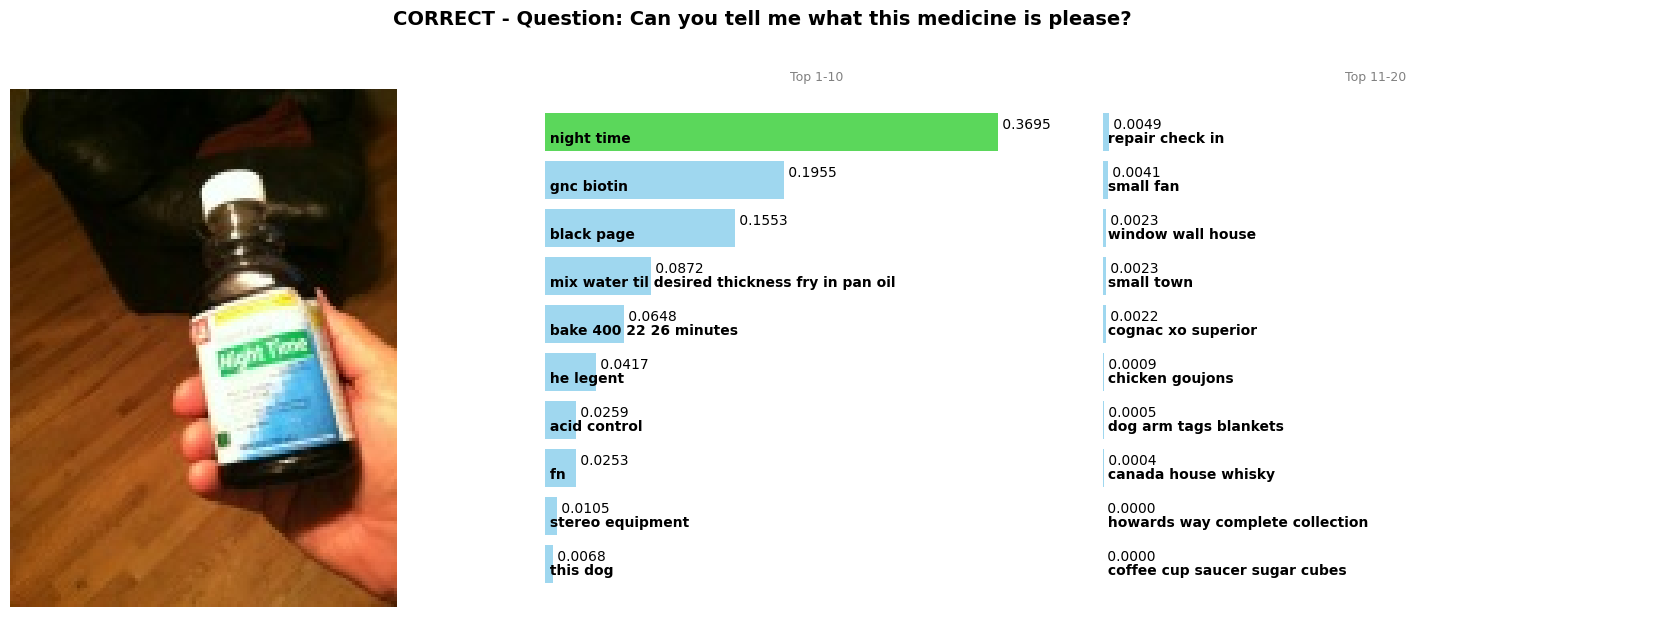

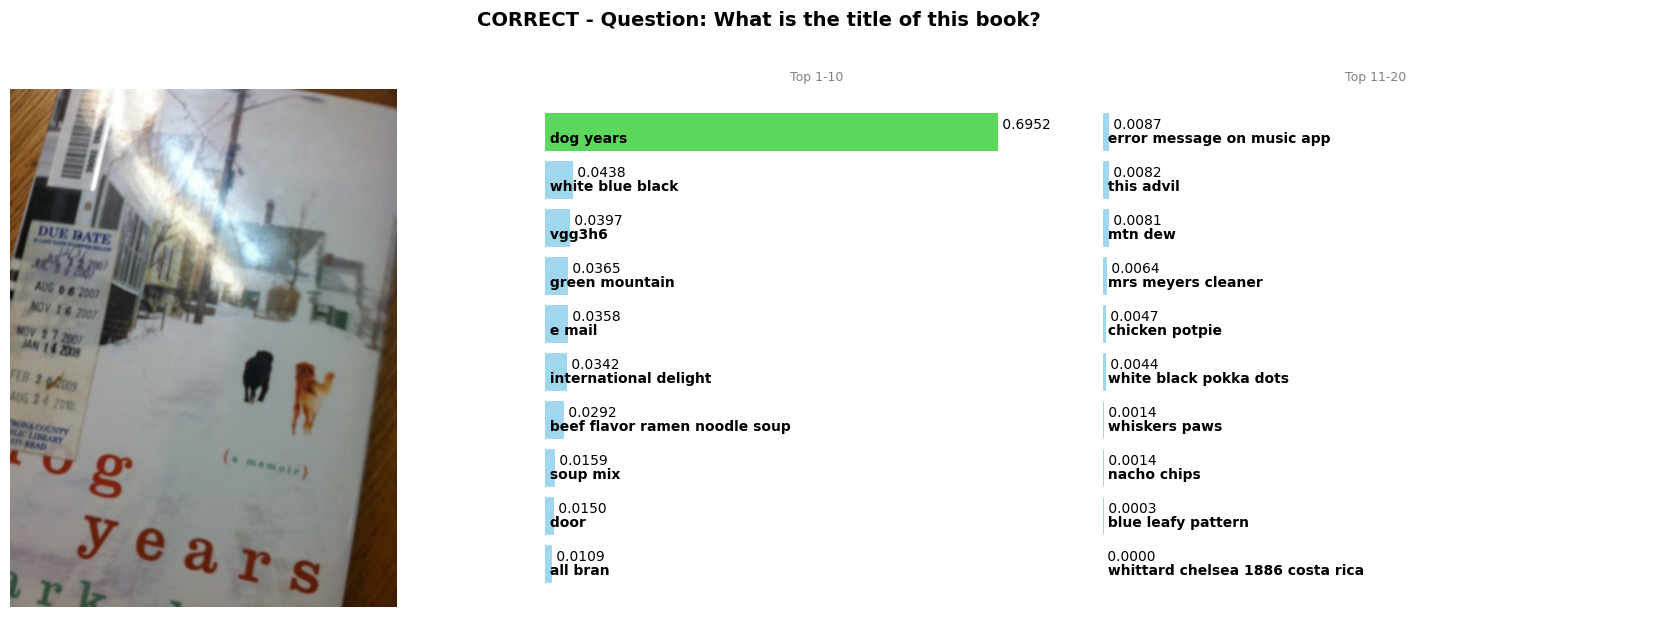

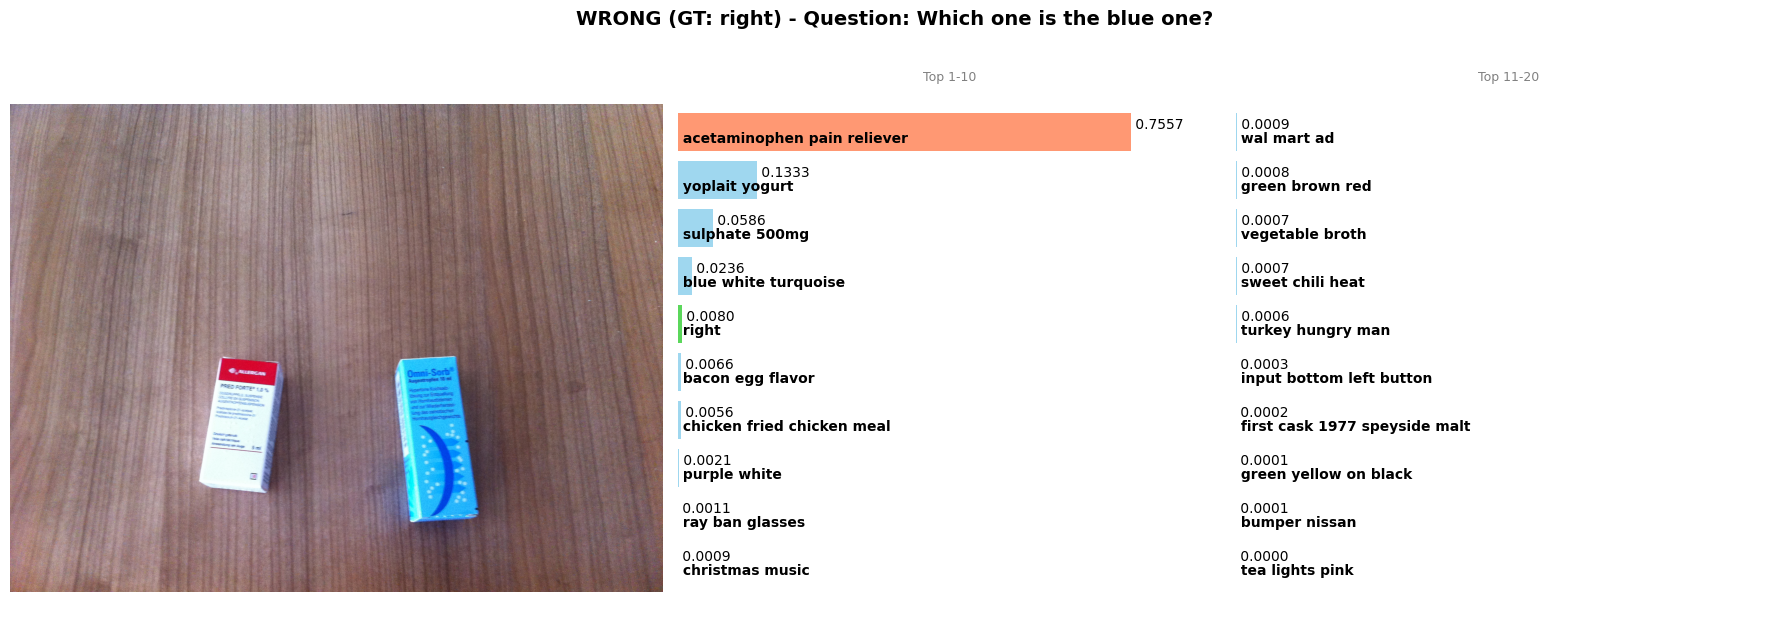

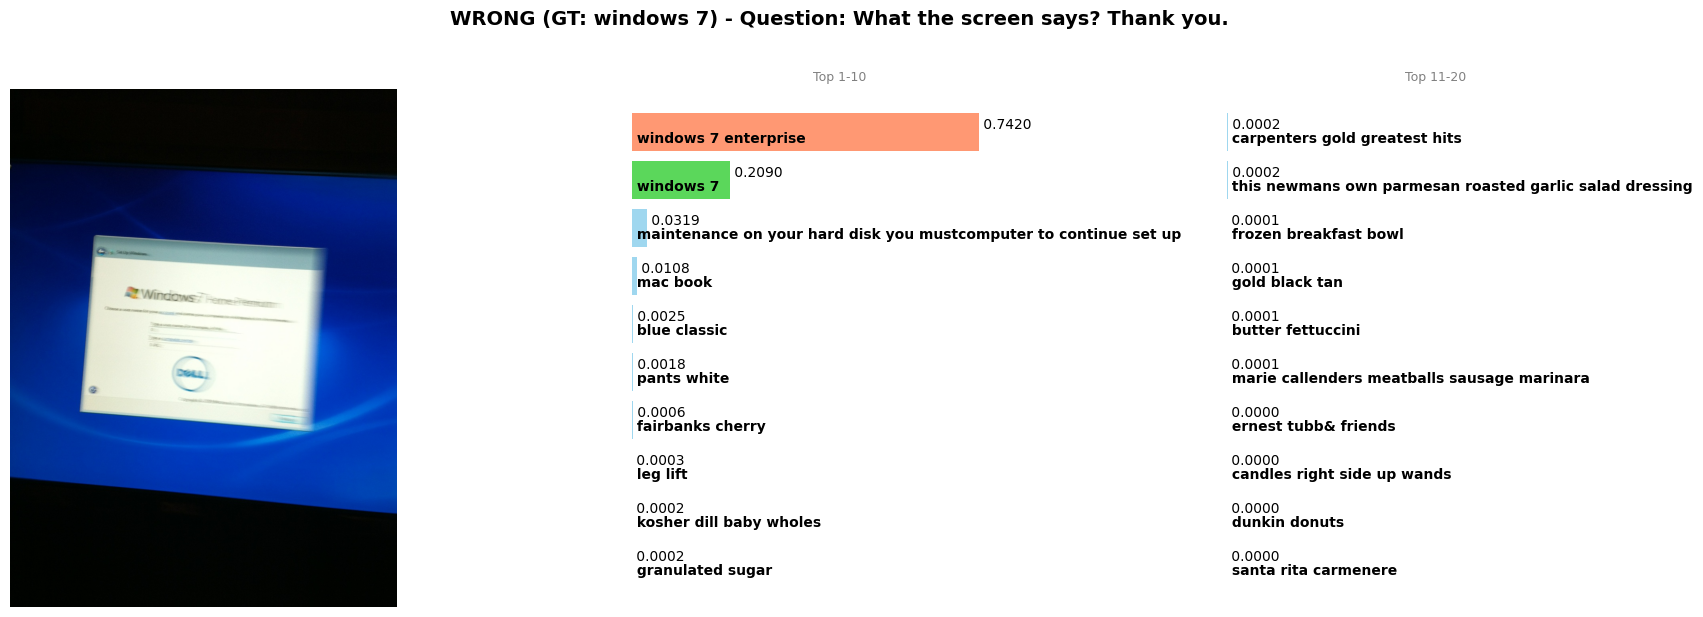

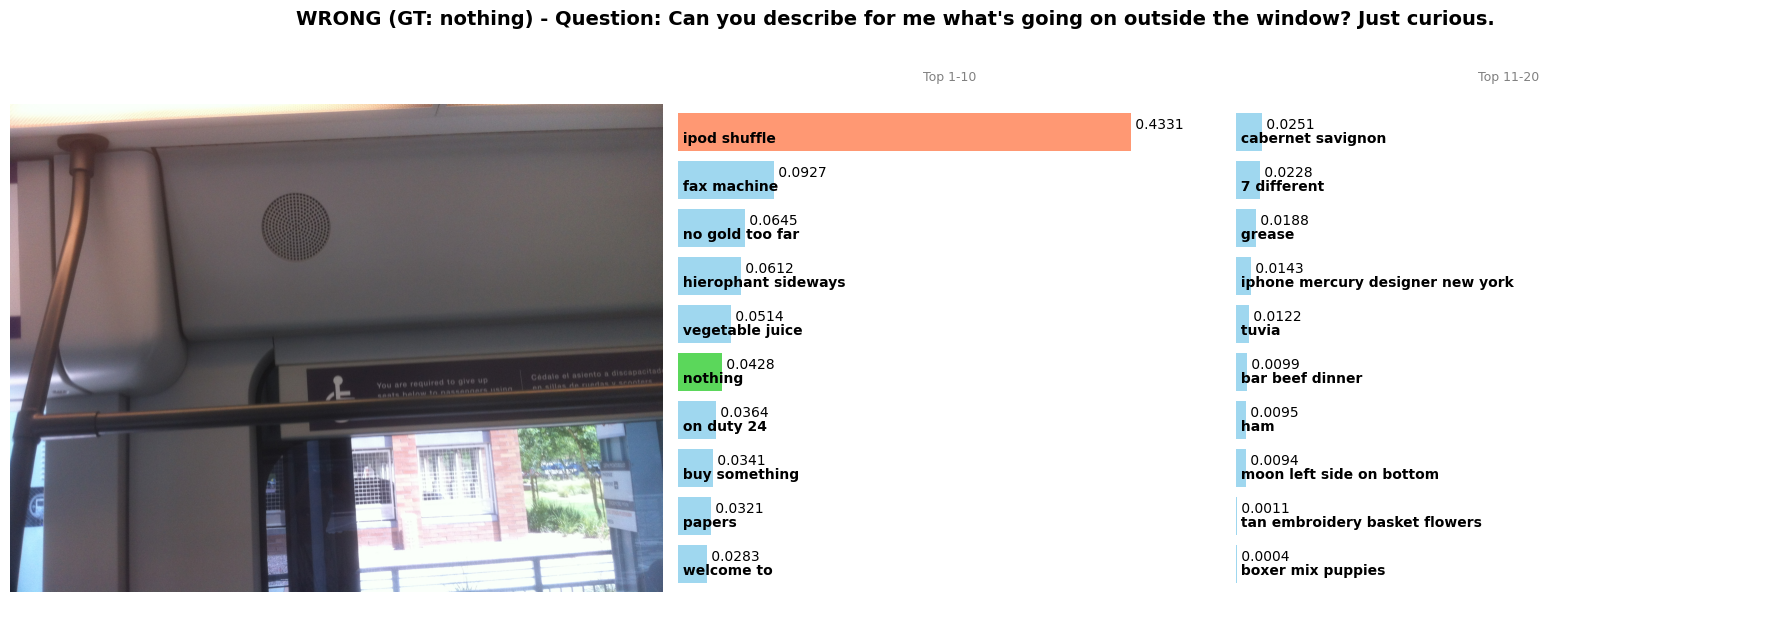

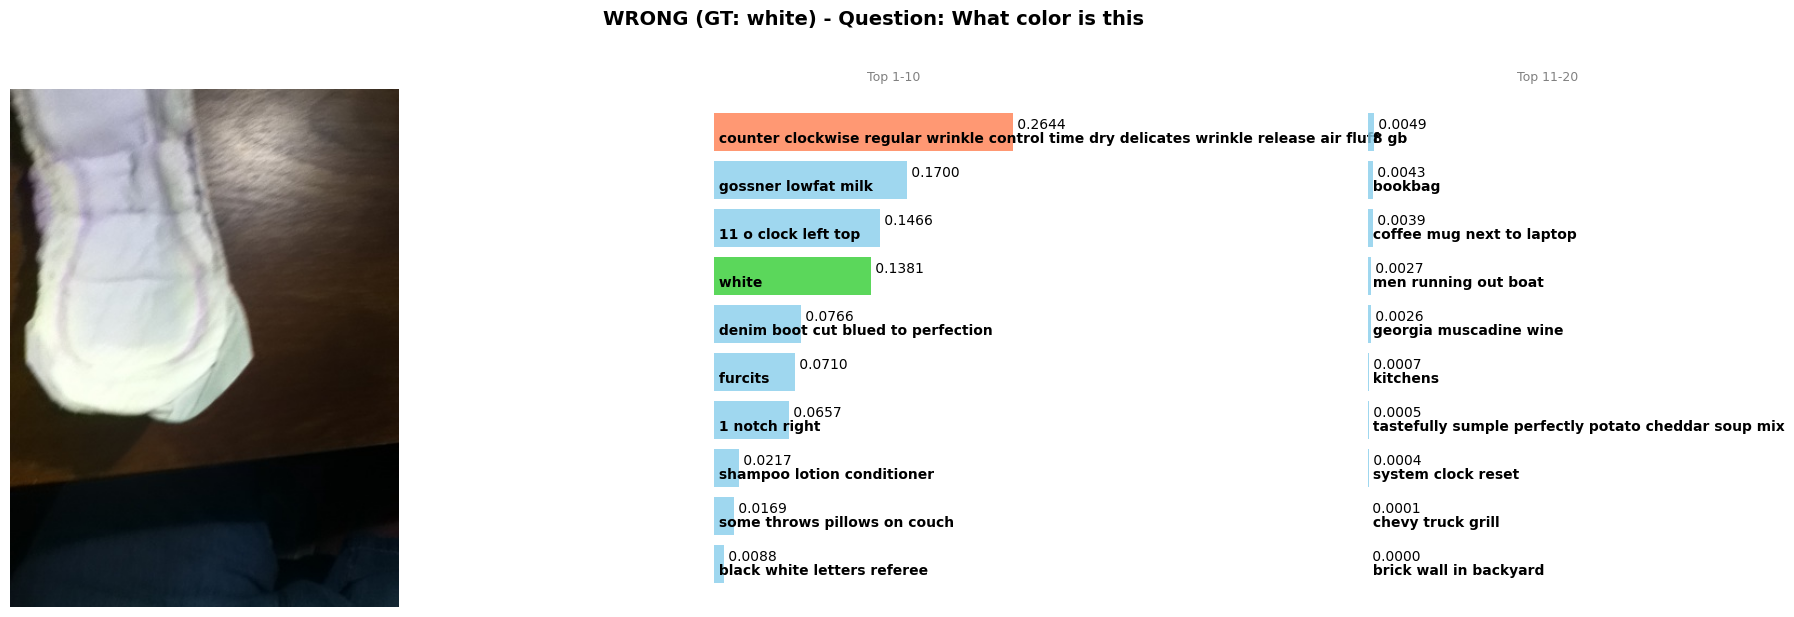

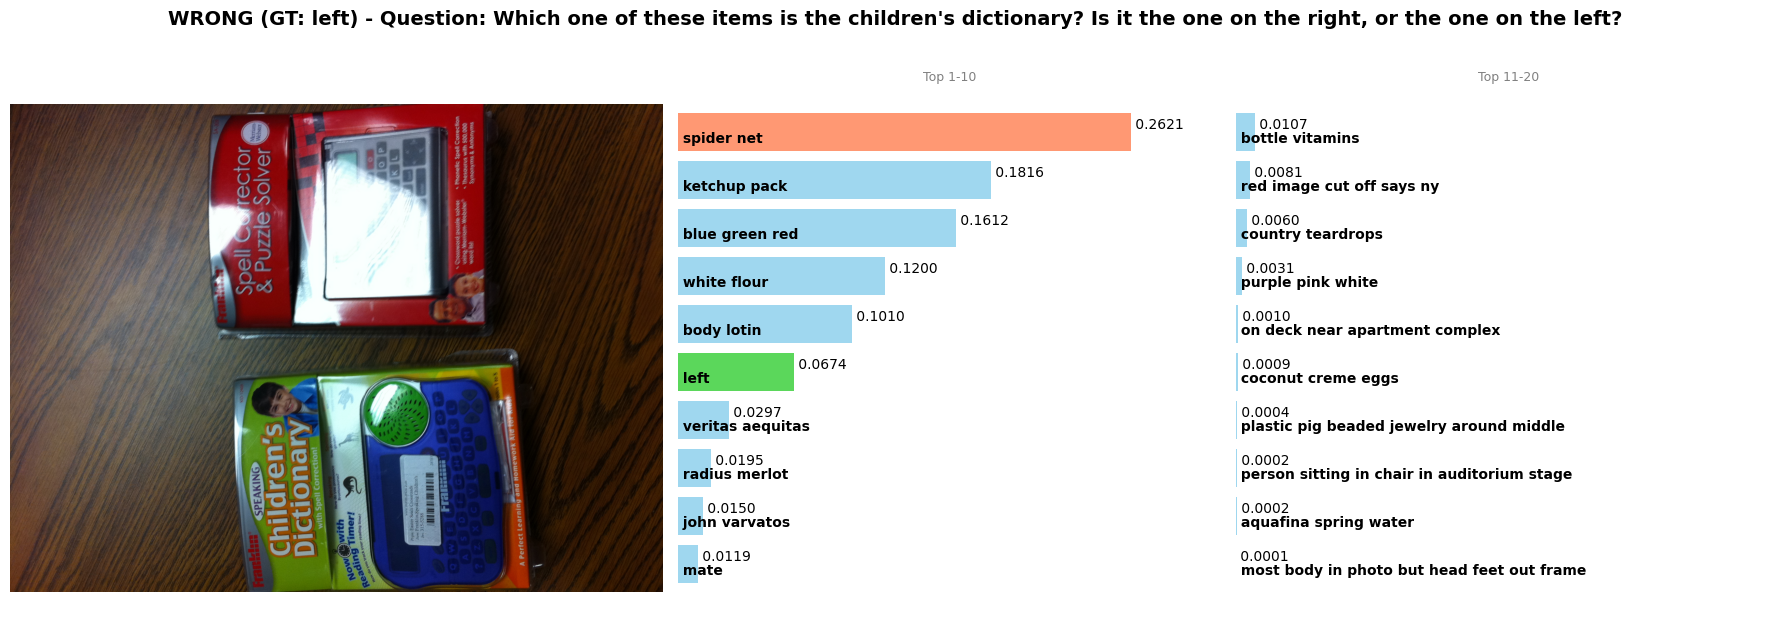

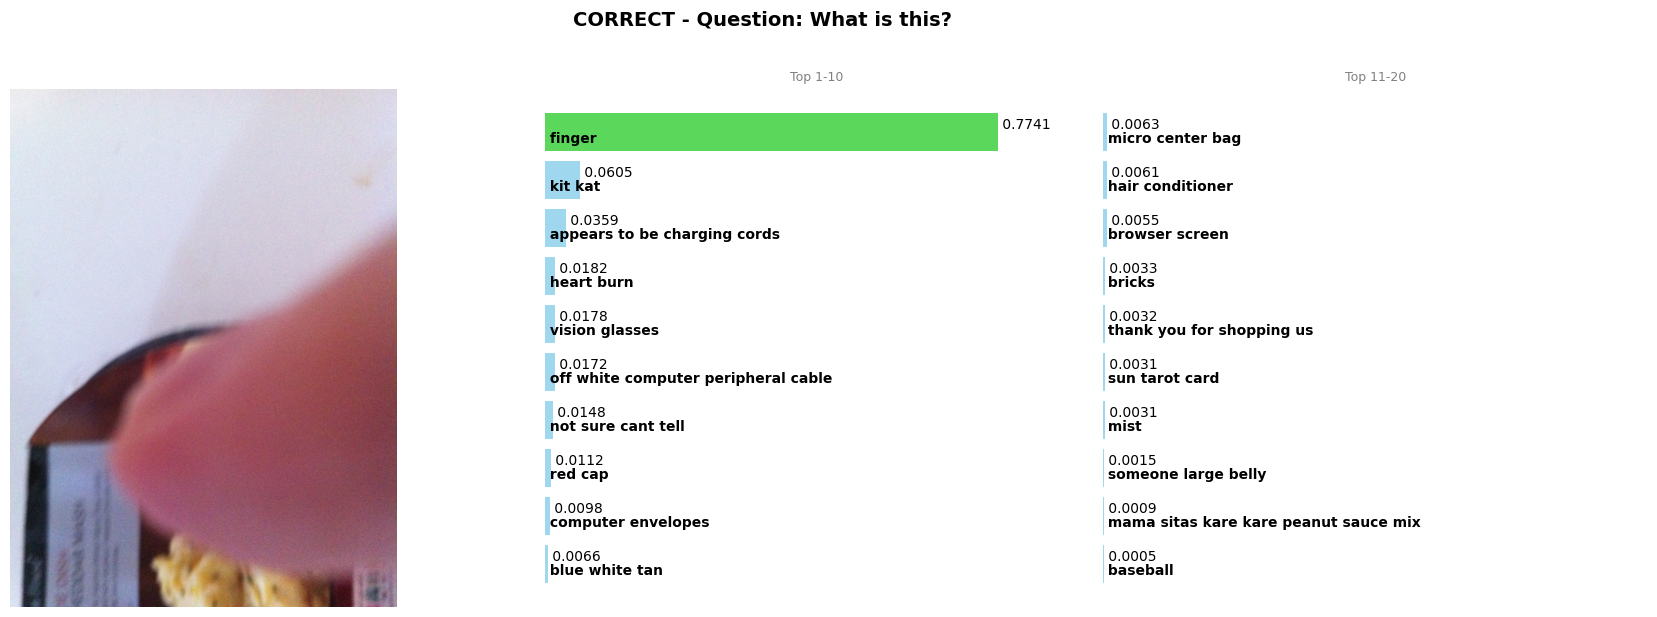

In [156]:
res = visualize_the_results(model_base, val_loader, device, temperature=None, nb_examples=8)

## Finetuning with initial question

In [157]:
acc = eval_loop(model_fnt, val_loader, device, temperature=temperature, log=True)
acc_list.append(acc)
logger.info(f'[FINAL TEST] Finetuning IQ Accuracy: {acc}')

2026-01-31 14:27:20.897 | INFO     | __main__:eval_loop:53 - Batch 0/12 	 running_accuracy = 0.7500
2026-01-31 14:27:21.767 | INFO     | __main__:eval_loop:53 - Batch 3/12 	 running_accuracy = 0.6875
2026-01-31 14:27:22.660 | INFO     | __main__:eval_loop:53 - Batch 6/12 	 running_accuracy = 0.6786
2026-01-31 14:27:23.484 | INFO     | __main__:eval_loop:53 - Batch 9/12 	 running_accuracy = 0.6250
2026-01-31 14:27:24.205 | INFO     | __main__:eval_loop:53 - Batch 12/12 	 running_accuracy = 0.6100
2026-01-31 14:27:24.205 | INFO     | __main__:<module>:3 - [FINAL TEST] Finetuning IQ Accuracy: 0.61


In [158]:
acc = eval_loop(model_fnt, rval_loader, device, temperature=temperature, log=True)
logger.info(f'[FINAL TEST] Finetuning RQ Accuracy: {acc}')

2026-01-31 14:27:24.527 | INFO     | __main__:eval_loop:53 - Batch 0/12 	 running_accuracy = 0.6250
2026-01-31 14:27:25.401 | INFO     | __main__:eval_loop:53 - Batch 3/12 	 running_accuracy = 0.7188
2026-01-31 14:27:26.294 | INFO     | __main__:eval_loop:53 - Batch 6/12 	 running_accuracy = 0.7143
2026-01-31 14:27:27.117 | INFO     | __main__:eval_loop:53 - Batch 9/12 	 running_accuracy = 0.6875
2026-01-31 14:27:27.837 | INFO     | __main__:eval_loop:53 - Batch 12/12 	 running_accuracy = 0.6700
2026-01-31 14:27:27.837 | INFO     | __main__:<module>:2 - [FINAL TEST] Finetuning RQ Accuracy: 0.67


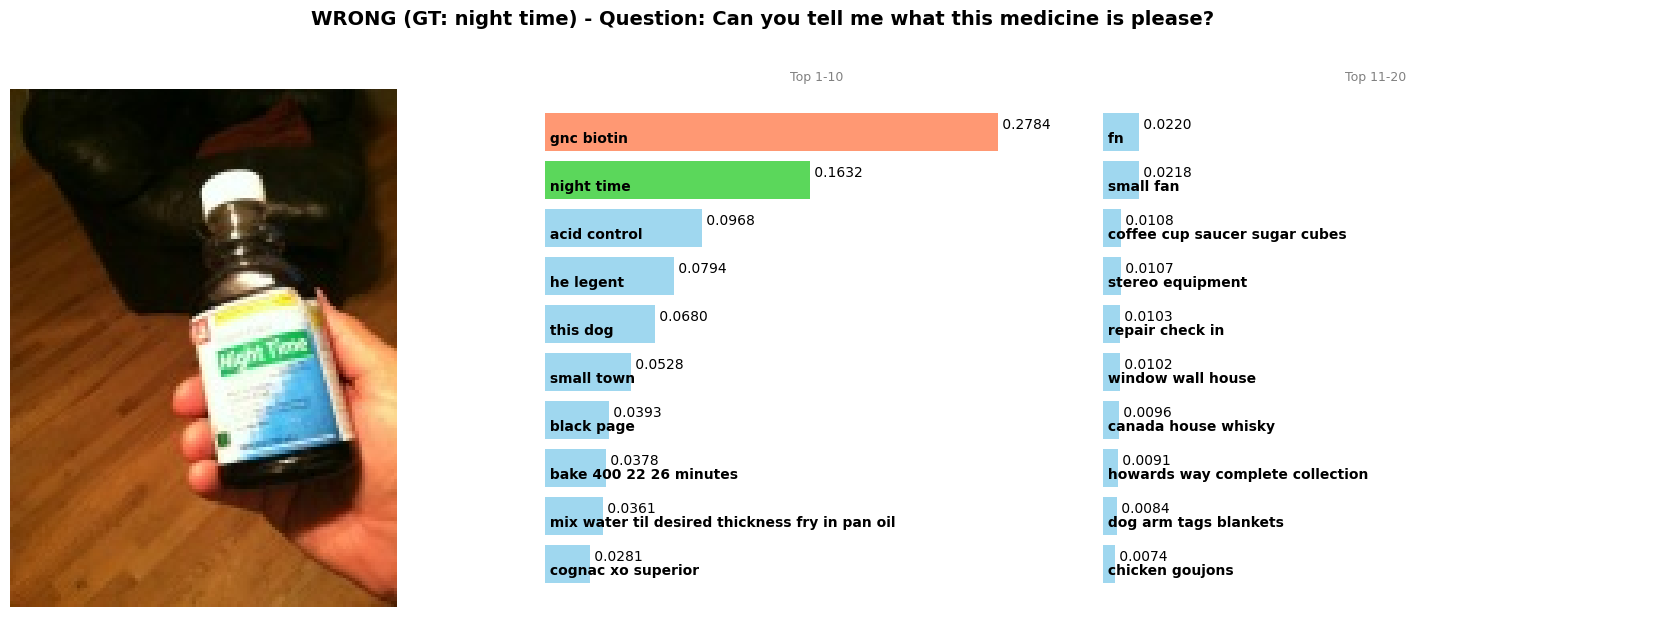

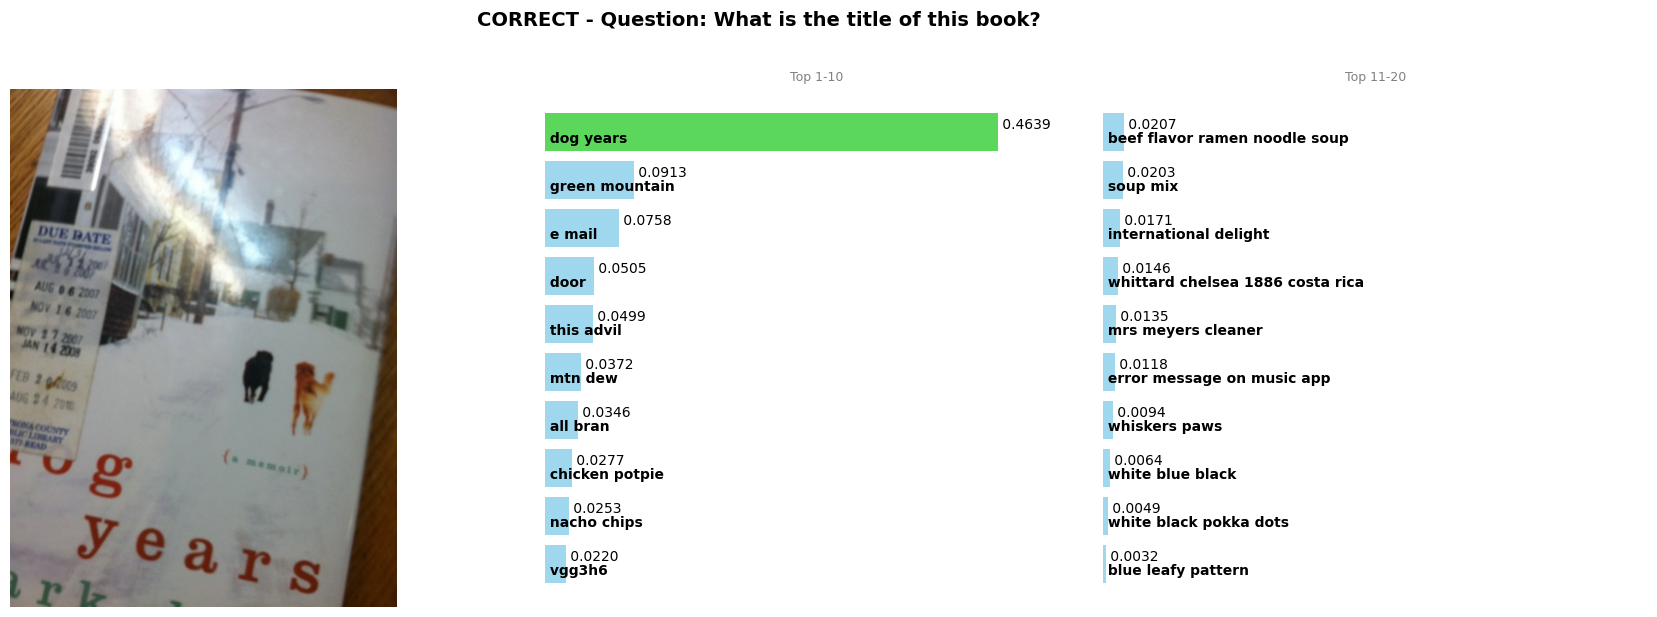

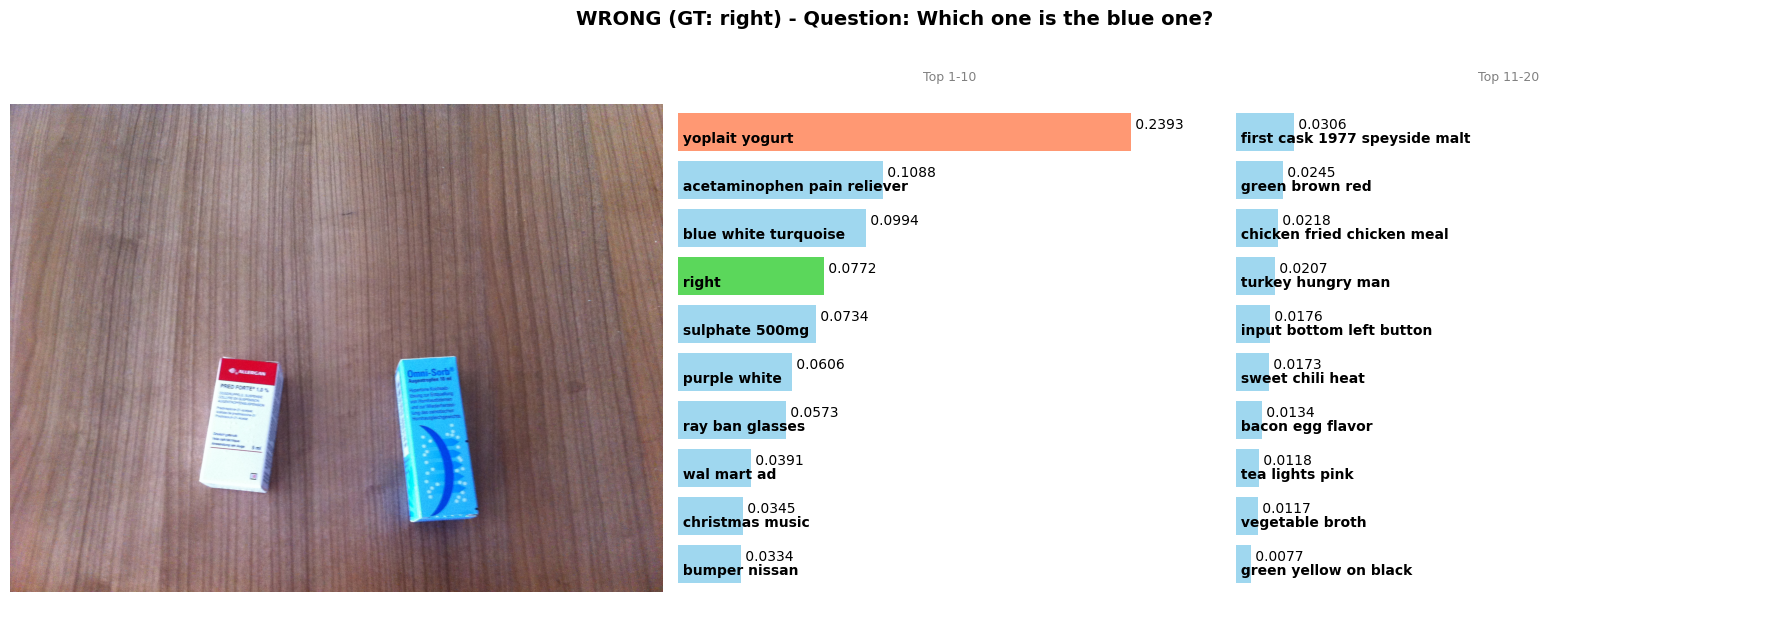

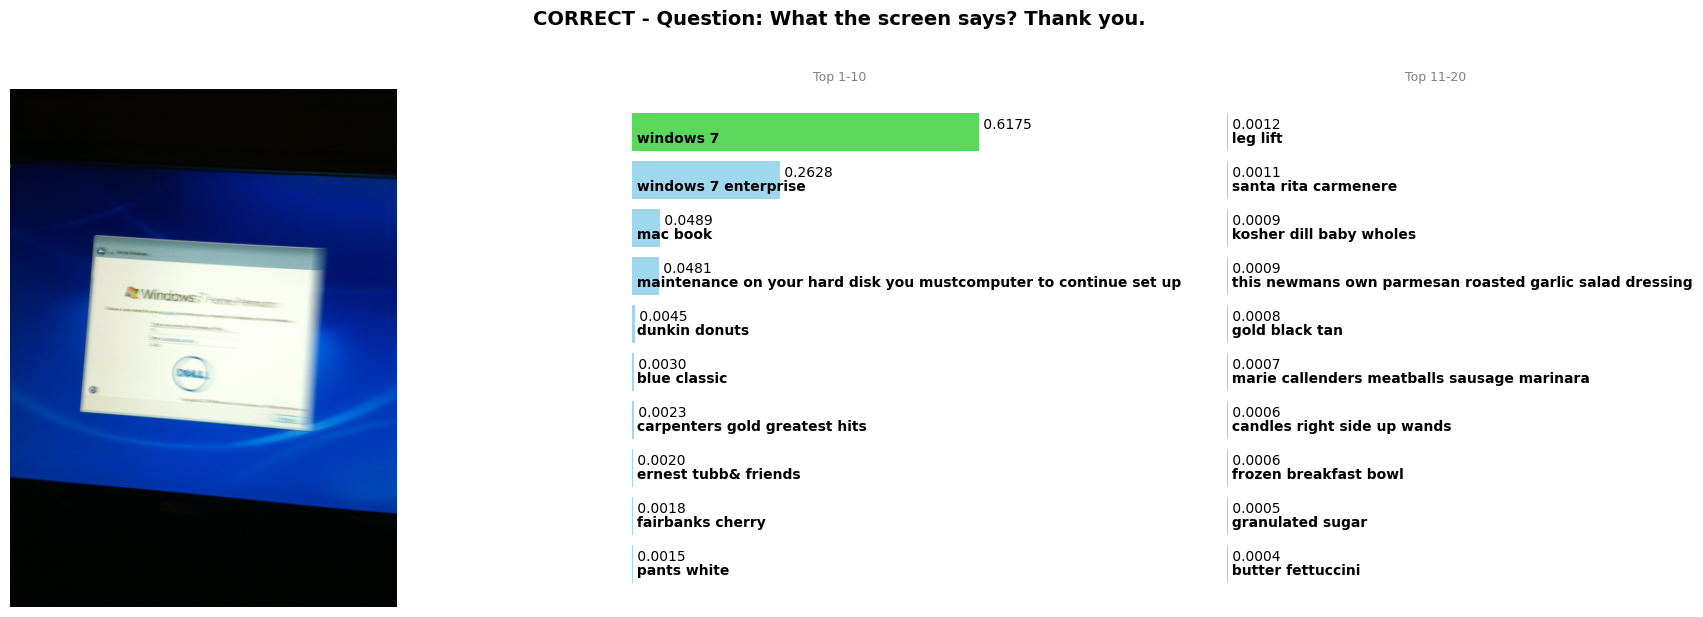

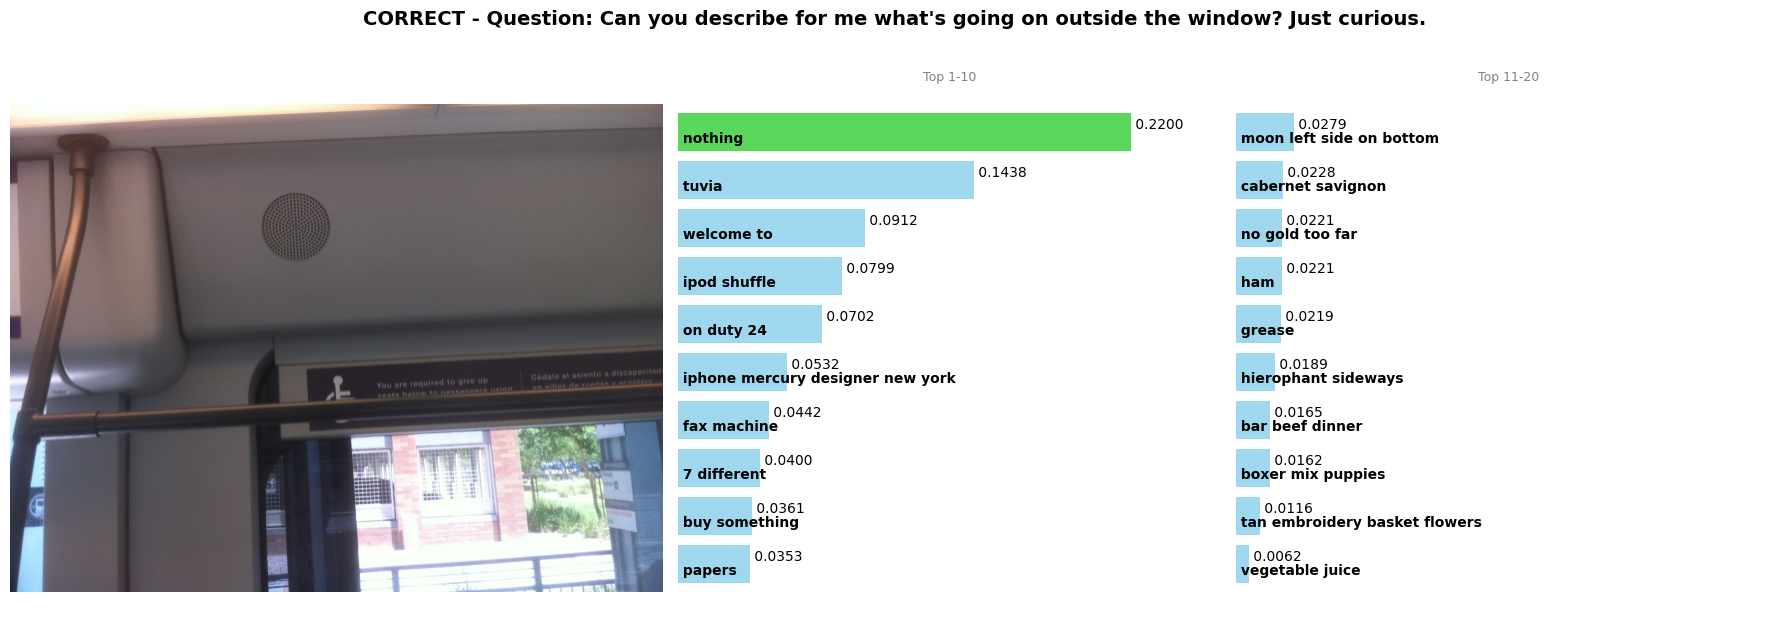

In [159]:
res = visualize_the_results(model_fnt, val_loader, device, temperature=temperature, nb_examples=5)

## Finetuning with reform Question

In [160]:
acc = eval_loop(model_fntrq, rval_loader, device, temperature=temperature, log=True)
acc_list.append(acc)
logger.info(f'[FINAL TEST] Finetuning with reform question RQ Accuracy: {acc}')

2026-01-31 14:27:29.464 | INFO     | __main__:eval_loop:53 - Batch 0/12 	 running_accuracy = 0.6250
2026-01-31 14:27:30.341 | INFO     | __main__:eval_loop:53 - Batch 3/12 	 running_accuracy = 0.7500
2026-01-31 14:27:31.237 | INFO     | __main__:eval_loop:53 - Batch 6/12 	 running_accuracy = 0.6786
2026-01-31 14:27:32.067 | INFO     | __main__:eval_loop:53 - Batch 9/12 	 running_accuracy = 0.7000
2026-01-31 14:27:32.788 | INFO     | __main__:eval_loop:53 - Batch 12/12 	 running_accuracy = 0.6800
2026-01-31 14:27:32.788 | INFO     | __main__:<module>:3 - [FINAL TEST] Finetuning with reform question RQ Accuracy: 0.68


In [161]:
acc = eval_loop(model_fntrq, val_loader, device, temperature=temperature, log=True)
logger.info(f'[FINAL TEST] Finetuning with reform question IQ Accuracy: {acc}')

2026-01-31 14:27:33.118 | INFO     | __main__:eval_loop:53 - Batch 0/12 	 running_accuracy = 0.6250
2026-01-31 14:27:33.994 | INFO     | __main__:eval_loop:53 - Batch 3/12 	 running_accuracy = 0.6250
2026-01-31 14:27:34.889 | INFO     | __main__:eval_loop:53 - Batch 6/12 	 running_accuracy = 0.5893
2026-01-31 14:27:35.718 | INFO     | __main__:eval_loop:53 - Batch 9/12 	 running_accuracy = 0.6125
2026-01-31 14:27:36.445 | INFO     | __main__:eval_loop:53 - Batch 12/12 	 running_accuracy = 0.6000
2026-01-31 14:27:36.446 | INFO     | __main__:<module>:2 - [FINAL TEST] Finetuning with reform question IQ Accuracy: 0.6


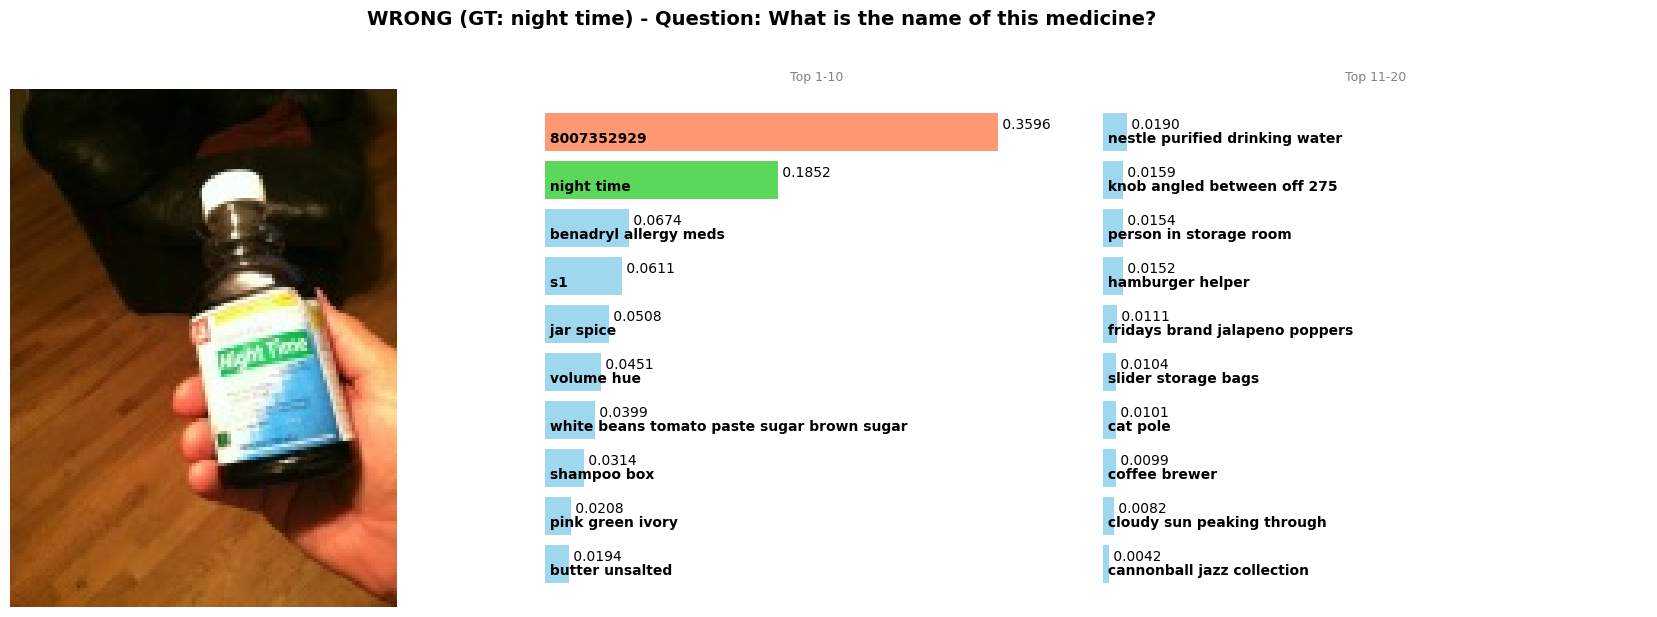

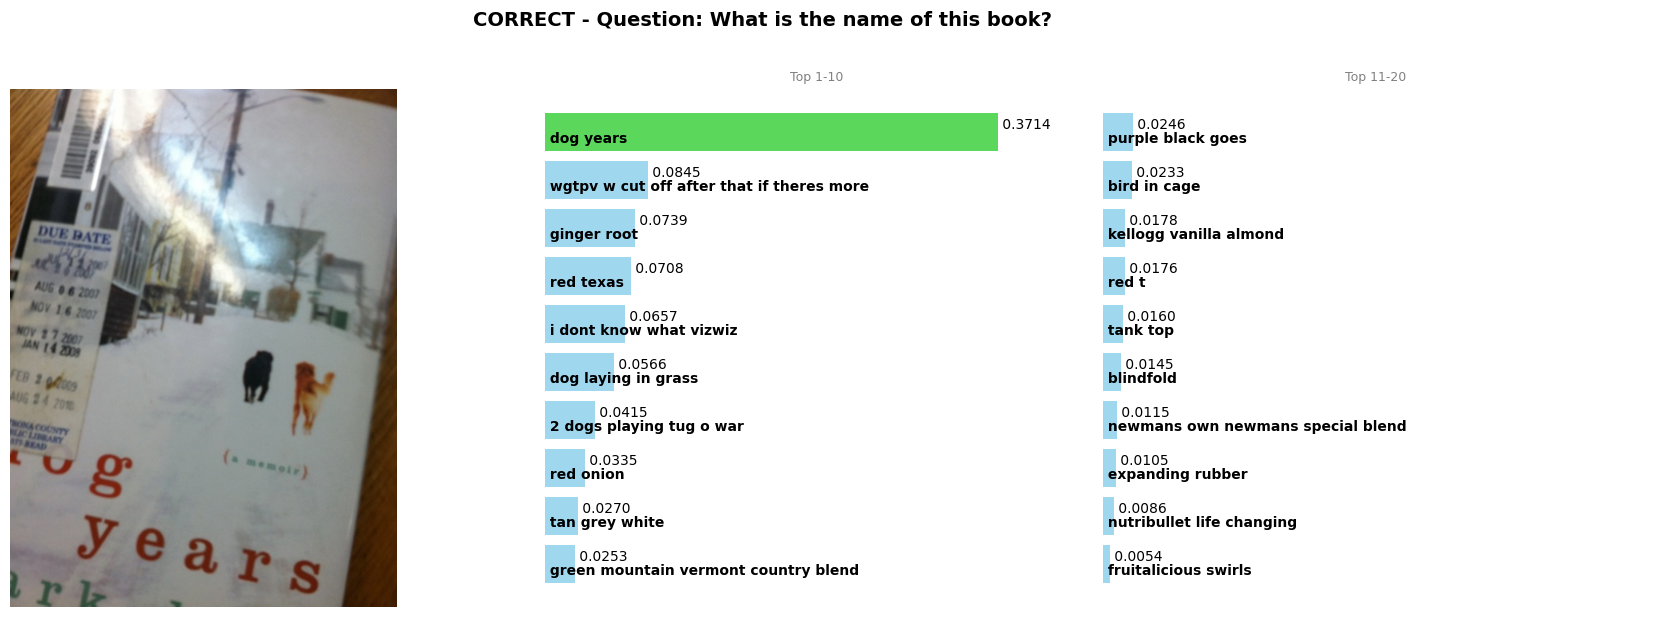

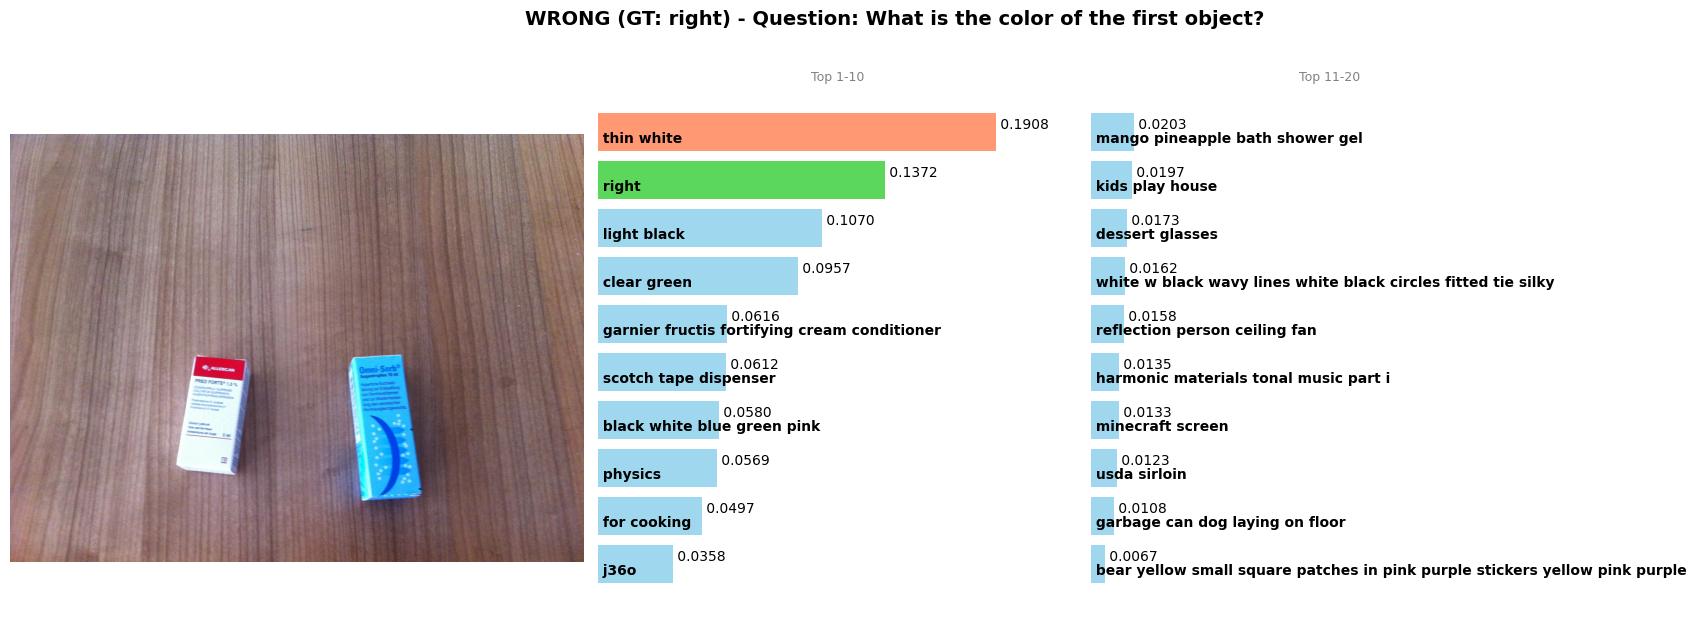

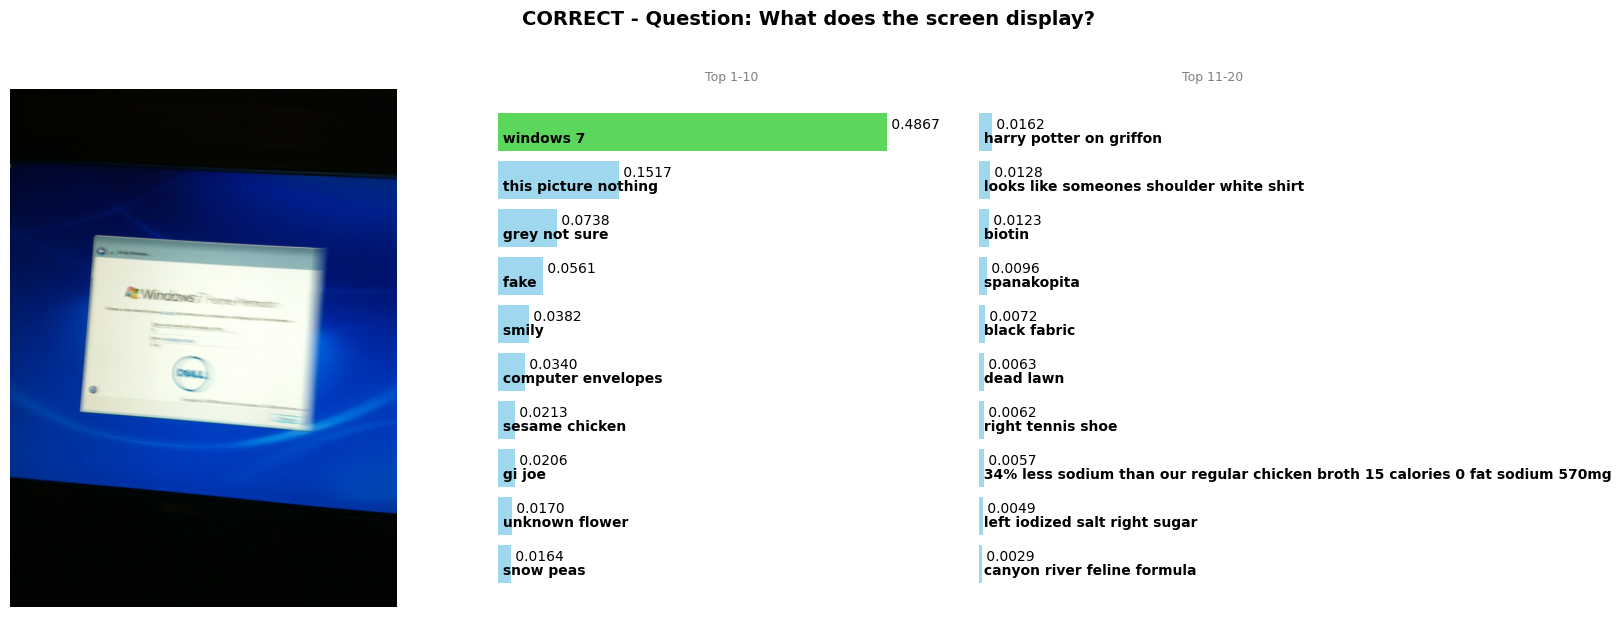

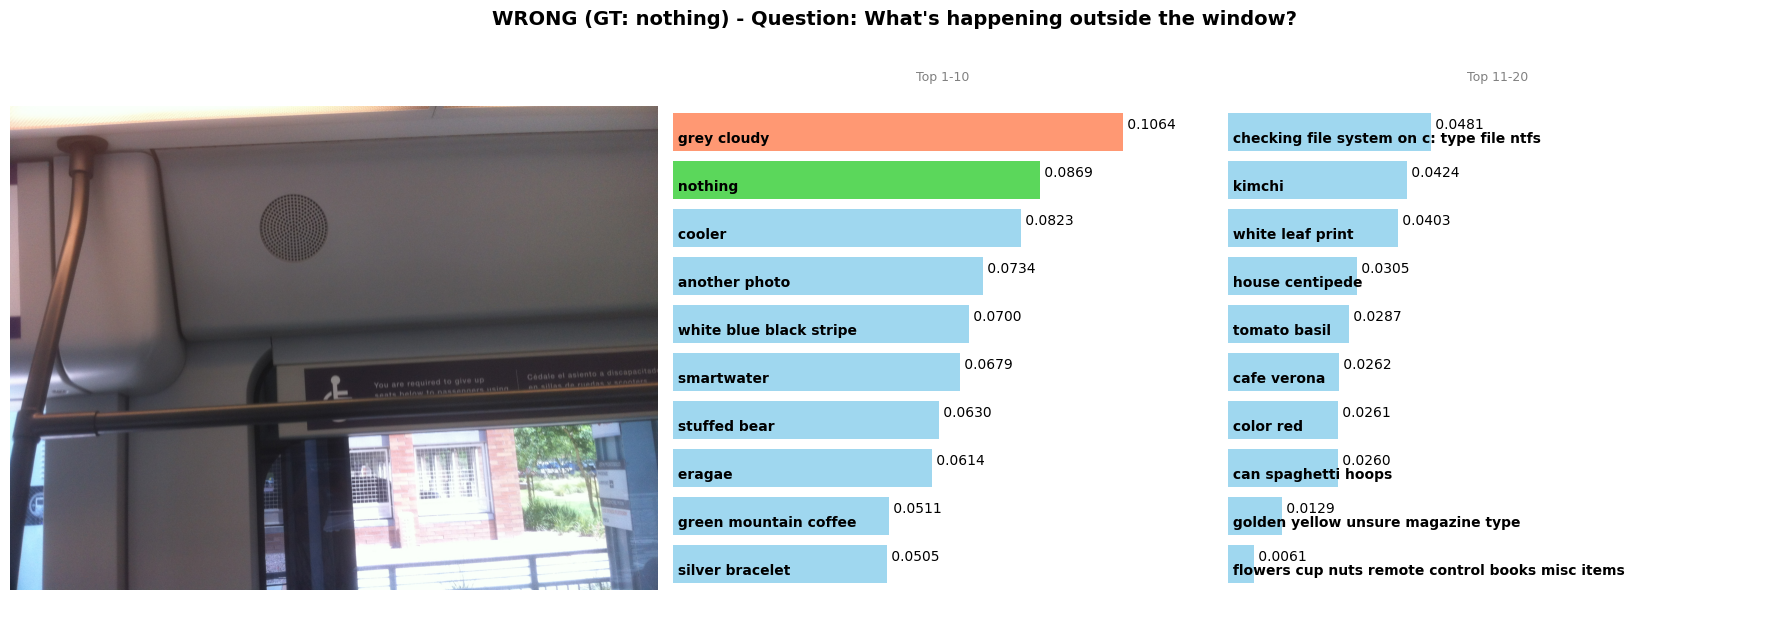

In [162]:
res = visualize_the_results(model_fntrq, rval_loader, device, temperature=temperature, nb_examples=5)

## Comparaison

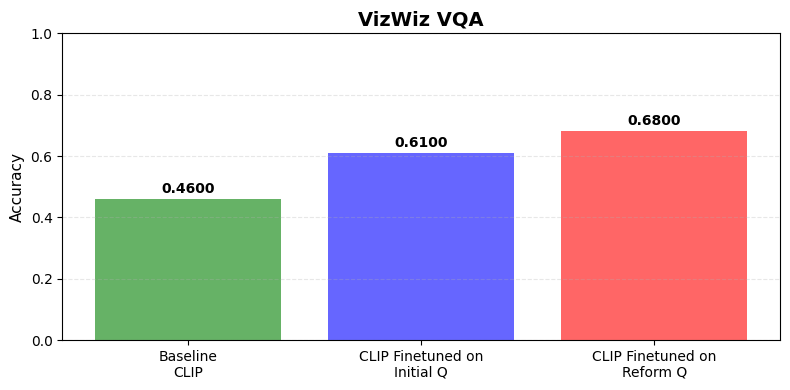

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

labels = ['Baseline\nCLIP', 'CLIP Finetuned on\nInitial Q', 'CLIP Finetuned on\nReform Q']

bars = plt.bar(labels, acc_list, color=['g', 'b', 'r'], alpha=0.6)

plt.ylabel("Accuracy", fontsize=11)
plt.ylim(0, 1)
plt.tick_params(axis='x', labelsize=10)
plt.title(f"VizWiz VQA", fontweight='bold', fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f"{height:.4f}",
            ha="center", va="bottom",
            fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

On remarque qu'en comparant les différents configurations sur les mêmes 100 images du split val, on obtient un gain en précision en reformulant les questions !